![Astrofisica Computacional](logo.png)

---
## Introduction to Smoothed Particle Hydrodynamics (SPH)

Eduard Larrañaga (ealarranaga@unal.edu.co)

---


### About this notebook

A simple model is presented that illustrates how to solve the equations of hydrodynamics from a model of smoothed elements (particles) known as Smoothed Particle Hydrodynamics (SPH).


---

## The SPH Model

In the SPH model, a fluid is represented by a collection of elements (particles) and each of them has certain relevant physical quantities such as position, speed, mass, density, etc.

As a particular example, we will consider a physical system described by the Euler equation for an ideal fluid without dissipation (in the Lagrangian frame),

\begin{equation}
\rho \frac{d\vec{v}}{dt} = - \vec{\nabla} P + \vec{f}
\end{equation}

where

- $\rho$: density
- $\vec{v}$: velocity of the fluid
- $P$: Pressure
- $\vec{f}$: Additional forces per volume unit

Considering an ideal gas, we introduce the state equation $P=P(\rho)$ and we combine it with the energy equation to obtain the polytropic state equation,

\begin{equation}
P = k\rho^{\gamma} = k\rho^{1+\frac{1}{n}},
\end{equation}

where $k$ is a proportionality constant, $\gamma$ is the adiabatic index and $n$ is called the polytropic index.


### The Kernel

To solve the system, we need to evaluate the acceleration of each element, $\frac{d\vec{v}}{dt}$. From Euler's equation it is seen that, to achieve this goal, some spatial derivatives must be evaluated. In the SPH model, we consider the following identity, valid for any scalar quantity $\Phi(\vec{r})$,

\begin{equation}
\Phi(\vec{r}) = \int \Phi(\vec{r}') \delta (\vec{r} - \vec{r}') d^3{r}'
\end{equation}

where $\delta (\vec{r})$ is the Dirac Delta function. This relationship will be modified by introducing a *smoothed kernel* $W(\vec{r};h)$ that will replace the Dirac Delta. Here, the  parameter $h$ corresponds to the smoothing length scale. The kernel must be a non-negative function, invariant under parity, and must satisfy the conditions

\begin{equation}
\int W(\vec{r};h) d^3{r} = 1
\end{equation}

and

\begin{equation}
\lim_{h\rightarrow 0} W(\vec{r};h) = \delta(\vec{r}).
\end{equation}


Two examples of kernel used in the literature are:

* **Gaussian kernel**

In this case we have the function

\begin{equation}
W(\vec{r};h) = \left( \frac{1}{h\sqrt{\pi}}\right)^d \exp \left( -\frac{\left| \vec{r} \right|^2}{h^2}\right)
\end{equation}

where $d$ is the dimension of the problem. This kernel is the most suitable for solving physical problems [[Gingold and Monaghan, 1977]](https://ui.adsabs.harvard.edu/abs/1977MNRAS.181..375G/abstract).

* **Cubic spline kernel**

In this case, the function that acts as kernel is

\begin{equation}
W(\vec{r};h) = C_d (h)
\begin{cases}
(2-q)^3 - 4(1-q)^3 & \hspace{1cm} 0\leq q <1 \\
(2-q)^3 & \hspace{1cm} 1\leq q <2 \\
0 & \hspace{1cm} q\geq 2
\end{cases}
\end{equation}

where $q = \frac{\left|\textbf{r}\right|}{h}$ and the coefficient depends on the dimensionality of the problem in the form

\begin{equation}
C_d (h) =
\begin{cases}
\frac{1}{6h} & \hspace{1cm} d = 1\\
\frac{5}{14\pi h^2} & \hspace{1cm} d = 2\\
\frac{1}{4\pi h^3} & \hspace{1cm} d = 3
\end{cases}
\end{equation}

This kernel can notably reduce computation time because it is a function with compact support (i.e. the set where it is not null forms a closed and bounded set) and therefore the interaction between two particles mediated by the kernel is simply zero if they are far enough apart from each other.

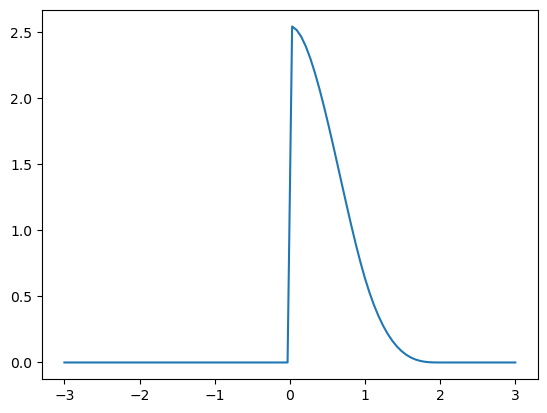

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def cs(q,h):
    C = 1/(4*np.pi*h**3)
    if q>=0 and q<1:
        return C*((2-q)**3 - 4*(1-q)**3)
    elif q>=1 and q<2:
        return C*((2-q)**3)
    else:
        return 0

h = 0.5
qq = np.linspace(-3,3,100)
csqq = np.zeros(100)
for i in range(len(qq)):
    csqq[i] = cs(qq[i],h)

plt.figure()
plt.plot(qq, csqq)
plt.show()

---

## Smooth Kernel Approximations and Derivatives

The identity for the function $\Phi(\vec{r})$ using the Dirac Delta is approximated by introducing the smoothed kernel. In this way we obtain the first approximation

\begin{equation}
\Phi(\vec{r}) \approx \Phi^{(1)} (\vec{r}) = \int \Phi(\vec{r}´) W(\vec{r} - \vec{ r}';h) d^3{r}'
\end{equation}

Now, discretizing the system introduces a next level of approximation, in which the integral over the entire volume in which the fluid is found is replaced by a sum of the discrete elements considered ($j=1,2,. ..,N$). Thus, we have

\begin{equation}
\Phi^{(1)}(\vec{r}) \approx \Phi^{(2)} (\vec{r}) = \sum_j \Phi(\vec{r}_j) W(\vec{ r} - \vec{r}_j;h) \Delta V_j
\end{equation}

where $\vec{r}_j$ represents the position of the particle $j$ and the element of volume is $\Delta V_j = \frac{m_j}{\rho_j}$ with $m_j$ the mass of element $j$ and $\rho_j$ its density.

From these relations, the gradient of the function $\Phi(\vec{r})$ can be constructed in the form

\begin{equation}
\vec{\nabla} \Phi (\vec{r}) \approx \vec{\nabla} \Phi^{(2)} (\vec{r}) = \vec{\nabla} \sum_j \Phi( \vec{r}_j) W(\vec{r} - \vec{r}_j;h) \Delta V_j = \sum_j \Phi(\vec{r}_j) \vec{\nabla} W(\vec {r} - \vec{r}_j;h) \Delta V_j.
\end{equation}

Similarly, the Laplacian of $\Phi(\vec{r})$ will be

\begin{equation}
{\nabla}^2 \Phi (\vec{r}) \approx {\nabla}^2 \Phi^{(2)} (\vec{r}) = \sum_j \Phi(\vec {r}_j) {\nabla}^2 W(\vec{r} - \vec{r}_j;h) \Delta V_j
\end{equation}

## Writing the Differential Equation using the Smooth Kernel


Since we have the expressions for the derivatives of a scalar function $\Phi(\vec{r})$ using the smooth kernel, we can write Euler's equation in its SPH method representation. First, we have the equation in the form

\begin{equation}
\frac{d\vec{v}}{dt} = - \frac{1}{\rho} \vec{\nabla} P + \frac{1}{\rho} \vec{f}.
\end{equation}

The first term on the right hand side can be rewritten as

\begin{equation}
 \frac{1}{\rho} \vec{\nabla} P = \vec{\nabla} \left( \frac{P}{\rho}\right) + \frac{P}{\rho^2} \vec{\nabla} \rho
\end{equation}

Applying the representation in terms of the smooth kernel, these terms can be written in the form

\begin{align}
  \vec{\nabla} \left( \frac{P}{\rho}\right) \approx &\sum_j \frac{P_j}{\rho_j} \vec{\nabla} W(\vec{r} - \vec {r}_j;h) \Delta V_j = \sum_j \frac{P_j}{\rho_j} \vec{\nabla} W(\vec{r} - \vec{r}_j;h) \frac{m_j} {\rho_j} \\
  \vec{\nabla} \left( \frac{P}{\rho}\right) \approx & \sum_j m_j\frac{P_j}{\rho_j^2} \vec{\nabla} W(\vec{r} - \vec{r}_j;h)
\end{align}

and

\begin{align}
\frac{P}{\rho^2} \vec{\nabla} \rho \approx &\frac{P}{\rho^2} \sum_j \rho_j \vec{\nabla} W(\vec{r} - \vec{r}_j;h) \Delta V_j = \frac{P}{\rho^2} \sum_j \rho_j \vec{\nabla} W(\vec{r} - \vec{r}_j;h ) \frac{m_j}{\rho_j}\\
\frac{P}{\rho^2} \vec{\nabla} \rho \approx & \frac{P}{\rho^2} \sum_j m_j \vec{\nabla} W(\vec{r} - \vec{r}_j;h)
\end{align}

In this way, you will have

\begin{equation}
 \frac{1}{\rho} \vec{\nabla} P = \sum_j m_j\frac{P_j}{\rho_j^2} \vec{\nabla} W(\vec{r} - \vec{r} _j;h) + \frac{P}{\rho^2} \sum_j m_j \vec{\nabla} W(\vec{r} - \vec{r}_j;h) .
\end{equation}

Substituting into Euler's equation we get

\begin{align}
\frac{d\vec{v}}{dt} = &- \frac{1}{\rho} \vec{\nabla} P + \frac{1}{\rho} \vec{f} \\
\frac{d\vec{v}_i}{dt} = &- \sum_{j\neq i} m_j\frac{P_j}{\rho_j^2} \vec{\nabla} W(\vec{r} _i - \vec{r}_j;h) - \frac{P_i}{\rho_i^2} \sum_{j\neq i} m_j \vec{\nabla} W(\vec{r}_i - \vec{ r}_j;h) + \frac{1}{\rho_i} \vec{f}_i
\end{align}

where the condition $j \neq i$ has been introduced in the sums to avoid self-interaction of the elements. Hence, we can write the fundamental equation of the SPH method,

\begin{align}
\frac{d\vec{v}_i}{dt} = &- \sum_{j\neq i} m_j \left( \frac{P_j}{\rho_j^2} + \frac{P_i}{\rho_i^ 2} \right) \vec{\nabla} W(\vec{r}_i - \vec{r}_j;h) + \vec{a}_i = \vec{A}_i,
\end{align}

where the density appearing in these expressions can be obtained from

\begin{equation}
\rho_i = \sum_j m_j W(\vec{r}_i - \vec{r}_j;h).
\end{equation}

and $\vec{a}_i = \frac{1}{\rho_i} \vec{f}_i$ represents the acceleration of particle $i$ due to external forces (gravity, electromagnetism, etc.). In the case to be modeled, two accelerations $\vec{a}_i = \vec{g}_i + \vec{b}_i$ will be included. The terms correspond to the gravitational acceleration, $\vec{g}_i = - (\vec{\nabla} \phi)_i$ with $\phi$ the gravitational potential; and the acceleration due to a viscosity modeled in the form $\vec{b}_i = -\nu \vec{v}_i$, with $\nu$ a constant (dynamical viscosity) coefficient.

## Integración Temporal

Para resolver la ecuación de Euler se debe proveer un conjunto de condiciones iniciales, i.e. posiciones y velocidades, $\textbf{r}(0)$ y $\textbf{v}(0)$, para las $N$ partículas. Utilizando esta información, se puede integrar la ecuación diferencial utilizando métodos como Runge-Kutta o Leap Frog.

Usualmente se utiliza el método Leap Frog debido a que es explícito, de segundo orden y simpléctico. Como se presentó en una clase anterior, este algoritmo establece las ecuaciones iterativas para la posición y la velocidad en la forma

\begin{align}
\begin{cases}
\textbf{v}_{n+1/2} &=  \textbf{v}_{n-1/2} +   \textbf{A}_n \Delta t + \mathcal{O}(h^3)\\
\textbf{r}_{n+1} &=  \textbf{r}_n +  \textbf{v}_{n+1/2} \Delta t  + \mathcal{O}(h^3)
\end{cases}
\end{align}

Claramente, este algoritmo no se auto-inicia y por ello se necesita de un calculo previo de la velocidad en (medio)-tiempo anterior al instante inicial. Para este calculo, se utilizara el método de Euler (como es usual).

Una versión modificada del método Leap Frog conocida como la forma "kick-drift-kick" establece un medio avance en la velocidad, luego el avance espcaial y finalmente otro medio avance en la velocidad,

\begin{align}
\begin{cases}
\textbf{v}_{n+1/2} &=  \textbf{v}_{n} +   \textbf{A}_n \frac{\Delta t}{2} \\
\textbf{r}_{n+1} &=  \textbf{r}_n +  \textbf{v}_{n+1/2} \Delta t  \\
\textbf{v}_{n+1} &=  \textbf{v}_{n+1/2} +   \textbf{A}_{n+1} \frac{\Delta t}{2}
\end{cases}
\end{align}


NOTA: en el caso particular que se modelará se puede notar que la aceleración debida a la viscosidad depende de la velocidad, $\textbf{b}_i = -\nu \textbf{v}_i$, lo cual hace que el método no sea completamente explícito. Sin embargo, con la disposición del algorithmo "kick-drift-kick" no hay inconveniente con esta dependencia.

## Longitud Espacial de Suavizado y Tamaño de los Pasos Temporales 


El valor de la escala de suavizado $h$ debe escogerse de tal forma que sea lo suficientemente pequeña para mejorar el tiempo de computo pero lo suficeitnemente grande para que las particulas tengan con quien interactuar. Especialmente en el caso de los kernel con soporte compacto, el valor de $h$ no debe ser demasiado pequeño porque puede tenerse el caso en el que las particulas no interactuen entre si.

De esta forma existen varios criterios para escoger $h$. 
* De acuerdo con [[Gingold and Monaghan, 1977]](https://ui.adsabs.harvard.edu/abs/1977MNRAS.181..375G/abstract) es posible tomar su valor del orden de $\sqrt{\langle \textbf{r}^2\rangle - \langle \textbf{r}\rangle ^2}$, donde $\langle . \rangle$ denota el promedio sobre todas las partículas. 
 
* En [[Monaghan, 1992]](https://ui.adsabs.harvard.edu/abs/1992ARA%26A..30..543M/abstract), se considera un tamaño variable que se determina de tal forma que la bola de radio $h_i$ alrededor de cada particula debe contener $k$-vecinos.


De acuerdo con el análisis de estabilidad realizado por [[Gingold and Monaghan, 1977]](https://ui.adsabs.harvard.edu/abs/1977MNRAS.181..375G/abstract), el tamaño del paso temporal debe satisfacer

\begin{equation}
\Delta t \leq \min \left[ \frac{h}{v_{max}}, \sqrt{\frac{h}{F_{max}}} \right]
\end{equation}

donde $v_{max}$ y $F_{max}$ son la máxima velocidad y la máxima fuerza que siente la partícula en un tiempo dado. Este criteriio puede servir para generar un algoritmo con un paso temporal variable. Sin embargo en el caso particular que se analizará se trabajará con un $\Delta t$ constante y lo suficientemente pequeño para que siempre se cumpla esta condición de estabilidad. Un algoritmo con paso variable utilizando el mismo esquema y aplicado a un sistema mucho mas grande se puede consultar en [[Monaghan, 1992]](https://ui.adsabs.harvard.edu/abs/1992ARA%26A..30..543M/abstract).


---

## A Linear Model for Gravity

As a first (toy) model, the approximation of a linear gravitational acceleration is considered,

\begin{equation}
\vec{g}_i = - \lambda \vec{r}_i.
\end{equation}

This simplified model is inspired by the paper [[Monaghan & Price, 2004]](https://academic.oup.com/mnras/article/350/4/1449/986477), where toy stars 1- dimensional. Although it allows to see an interesting behavior, the model is not completely realistic and will later be modified to introduce a more appropriate gravitational field.

The value of the constant $\lambda$ is determined by considering Euler's equation,

\begin{equation}
\frac{d\vec{v}}{dt} = - \frac{1}{\rho} \vec{\nabla} P - \nu \vec{v} - \lambda \vec{r}.
\end{equation}

Due to the dissipation of viscosity, there will be an equilibrium state characterized by the condition$\vec{v} = 0$. This gives

\begin{equation}
0 = - \frac{1}{\rho} \vec{\nabla} P - \lambda \vec{r}.
\end{equation}

Using the polytropic equation, we have

\begin{align}
\lambda \vec{r} = & - \frac{1}{\rho} \vec{\nabla} \left( k \rho^{ 1 + \frac{1}{n}} \right) \\
\lambda \vec{r} = &- \frac{k \left( 1 + \frac{1}{n}\right)}{\rho} \rho^{\frac{1}{n}} \vec{\nabla} \rho
\end{align}

Considering only radial dependence, this equation can be written as

\begin{equation}
\lambda r = - k \left( 1 + \frac{1}{n}\right) \rho^{\frac{1}{n}-1} \frac{d\rho}{dr},
\end{equation}

which can be integrated in the form

\begin{equation}
- k \left( 1 + \frac{1}{n}\right) \int_{\rho (r)} ^0 \rho^{\frac{1}{n}-1} d\rho = \lambda \int_{r}^{R} r dr
\end{equation}

where $R$ is the radius of the star, so that $\rho(R) = 0$. Thus

\begin{equation}
 k \left( 1 + \frac{1}{n}\right)n \rho (r)^{\frac{1}{n}} = \frac{\lambda}{2}\left(R^2 - r^2 \right)
\end{equation}

\begin{equation}
k \left( 1 + n \right) \rho (r)^{\frac{1}{n}} = \frac{\lambda}{2}\left(R^2 - r^2 \right)
\end{equation}

from where the density profile is obtained

\begin{equation}
 \rho (r) = \left[ \frac{\lambda}{2k \left( 1 + n \right)}\left(R^2 - r^2 \right) \right]^n .
\end{equation}

Assuming that the star has a radius $R$ and a total mass $M$, we have the relation

\begin{equation}
M = \int \rho (r) d^d \textbf{r}
\end{equation}

where $d$ is the dimension of the space. From this relation, the value of $\lambda$ is obtained as

\begin{equation}
\lambda =
\begin{cases}
\frac{2k\pi^{-\frac{1}{n}}}{M} \left(\frac{M(1+n)}{R^2} \right)^{1+\frac{ 1}{n}} \hspace{1cm} d=2 \\
\frac{2k(1+n)\pi^{-\frac{3}{2n}}}{R^2} \left(\frac{M\Gamma (\frac{5}{2}+n) }{R^3 \Gamma (1+n)} \right)^{\frac{1}{n}} \hspace{1cm} d=3
\end{cases}
\end{equation}